In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Add, Dense, Conv2D
from keras.layers import Flatten
from keras.layers.convolutional import MaxPooling2D
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.utils import np_utils
from keras.preprocessing.image import load_img, img_to_array
%matplotlib inline

In [2]:
print(tf.version.VERSION)
tf.config.list_physical_devices('GPU')

2.7.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
model_type = 'vgg16'
model_home_dir = os.path.join(os.getcwd(), 'CNN_TASK_ODED',"model_type")
print(model_home_dir)
if not os.path.isdir(model_home_dir):
    print('Inside mkdir')
    os.makedirs(model_home_dir)

/home/ec2-user/SageMaker/Research/AWS/CNN_TASK_ODED/model_type


In [4]:
DATASET = 'celeb_A'
num_classes = 2
IMG_WIDTH = 178
IMG_HEIGHT = 218
input_shape=(218, 178, 3)
resize_shape = (130, 106, 3)
epochs = 200
lrate = 0.01
decay = lrate/epochs
batch_size = 32
seed = 7
np.random.seed(seed)

validate_dir = os.path.join("data","test")
train_dir = os.path.join("data","train")
MAIN_PATH = 'dataset/celeba/'
DATA_PATH = MAIN_PATH + 'img_align_celeba/img_align_celeba/'
ATTRIBUTE_PATH = MAIN_PATH + 'list_attr_celeba.csv'
PARTITION_PATH = MAIN_PATH + 'list_eval_partition.csv'

save_dir = os.path.join(model_home_dir, 'saved_models')

model_name = DATASET+'_'+'%s_model.{epoch:03d}.h5' % model_type

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
print("Model Type: ",model_type)
print("Model File: ",filepath)
EXAMPLE_PIC = DATA_PATH + '000002.jpg'
NUM_SAMPLES = 20000


Model Type:  vgg16
Model File:  /home/ec2-user/SageMaker/Research/AWS/CNN_TASK_ODED/model_type/saved_models/celeb_A_vgg16_model.{epoch:03d}.h5


In [5]:
attr_df = pd.read_csv(ATTRIBUTE_PATH, index_col='image_id')
attr_df.replace(to_replace=-1, value=0, inplace=True)
# attr_df.head()

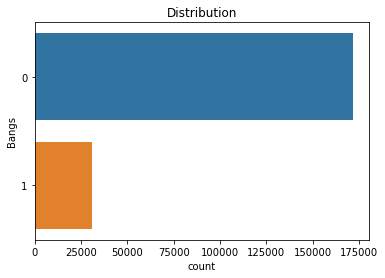

In [6]:
plt.title('Distribution')
sns.countplot(y = 'Bangs', data=attr_df)
plt.show()

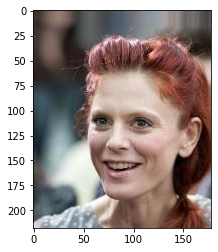

In [7]:
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
img = load_img(EXAMPLE_PIC)
plt.imshow(img)
plt.show()

In [8]:
parti_df = pd.read_csv(PARTITION_PATH, index_col='image_id')
sampling_df = attr_df[['Bangs']].join(parti_df)

In [9]:
# Sampling
def load_reshape_img(filename):
    img = load_img(filename)
    img = tf.image.resize(img, (130, 106))
    img_array = img_to_array(img)/255
#     img_array = img_array.reshape((1,) + img_array.shape)
    return img_array

def sampling(partition, sample_size, sampling_df):
    parti_mask = sampling_df['partition'] == partition
    Bangs_mask = sampling_df['Bangs'] == 1
    NO_Bangs_mask = sampling_df['Bangs'] == 0
    sampled_df = pd.concat([
        sampling_df[parti_mask & Bangs_mask].sample(sample_size//2),
        sampling_df[parti_mask & NO_Bangs_mask].sample(sample_size//2)
    ])
    
    if partition != 2:
        x = np.array([load_reshape_img(DATA_PATH + filename) for filename in sampled_df.index])
#         x = x.reshape(x.shape[0], 130, 106, 3)
        y = np_utils.to_categorical(sampled_df['Bangs'],2)
#     else:
#         x = []
#         y = []
#         for index, target in sampled_df.iterrows():
#             im = cv2.imread(DATA_PATH + index) # return BGR
#             im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0 # convert it to RGB for consistency
#             im = np.expand_dims(im, axis =0)
#             x.append(im)
#             y.append(target['Male'])
            
    return x, y

In [10]:
X, Y = sampling(0, NUM_SAMPLES, sampling_df)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15)

print(y_train.shape, y_test.shape)
print(X_train.shape, X_test.shape)

(17000, 2) (3000, 2)
(17000, 130, 106, 3) (3000, 130, 106, 3)


In [12]:
# y_train = np_utils.to_categorical(y_train,)
# y_test = np_utils.to_categorical(y_test,)
y_train = np.delete(y_train,1,1)
y_test = np.delete(y_test,1,1)
print(y_train.shape, y_test.shape)

(17000, 1) (3000, 1)


------------------concatenate train-------------------


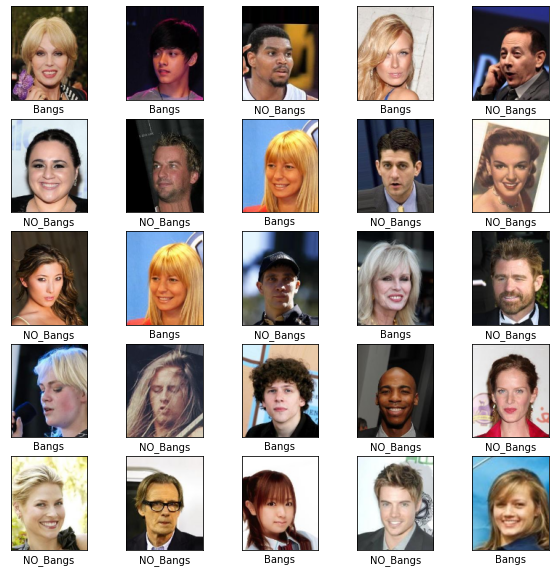

------------------concatenate test-------------------


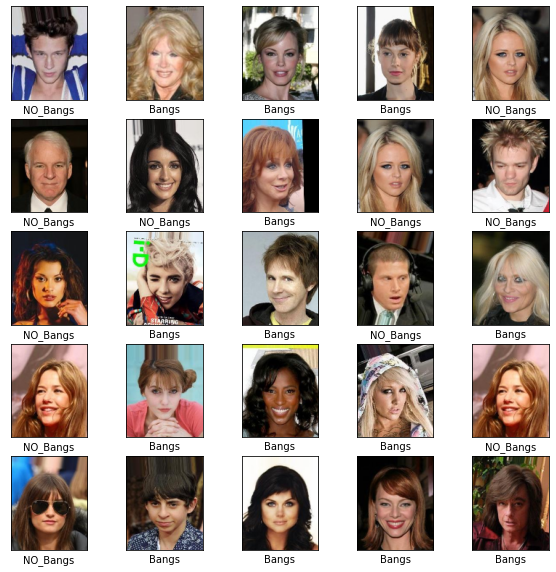

In [13]:
class_names = ['Bangs', 'NO_Bangs']

print("------------------concatenate train-------------------")
plt.figure(figsize=(10,10))
for i in range(25):
    j = random.randint(0,1700)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[j])
    plt.xlabel(class_names[y_train[j][0].astype('int')])
plt.show()

print("------------------concatenate test-------------------")
plt.figure(figsize=(10,10))
for i in range(25):
    j = random.randint(0,300) 
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[j])
    plt.xlabel(class_names[y_test[j][0].astype('int')])
plt.show()

In [14]:
# from numpy import save
# save('../data/young/y_train.npy', y_train)
# save('../data/young/y_test.npy', y_test)
# save('../data/young/X_train.npy', X_train)
# save('../data/young/X_test.npy', X_test)

In [15]:
# from numpy import load
# y_train = load('../data/young/y_train.npy')
# y_test  = load('../data/young/y_test.npy')
# X_train = load('../data/young/X_train.npy')
# X_test  = load('../data/young/X_test.npy')
               

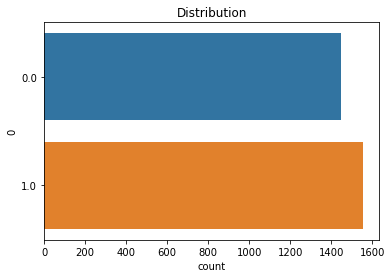

----------------test------------------
 Bangs:1445
 NO_Bangs:1555
----------------train------------------
 Bangs:8555
 NO_Bangs:8445


In [16]:
import seaborn as sns
import pandas as pd


plt.title('Distribution')
sns.countplot(y = 0, data=pd.DataFrame(y_test))
plt.show()


print('----------------test------------------')
print(f' Bangs:{np.count_nonzero(y_test == 0)}')
print(f' NO_Bangs:{np.count_nonzero(y_test == 1)}')

print('----------------train------------------')
print(f' Bangs:{np.count_nonzero(y_train == 0)}')
print(f' NO_Bangs:{np.count_nonzero(y_train == 1)}')


In [17]:
from tensorflow.keras.layers import Dropout
def vgg16(input_shape, num_classes):
  model = Sequential()
  model.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

#   model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"))
#   model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"))
#   model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

#   model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
#   model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
#   model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
#   model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

#   model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
#   model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
#   model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
#   model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=1, activation="sigmoid"))

  return model

In [18]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [19]:
# Prepare callbacks for model saving and for learning rate adjustment.

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler,early_stopping]


In [20]:
model = vgg16(resize_shape,num_classes)

# Compile model

# optimizer = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss= 'binary_crossentropy' , optimizer=optimizer, metrics=['accuracy'])
print("Model Summary of ",model_type)
print(model.summary())



Model Summary of  vgg16
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 130, 106, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 130, 106, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 65, 53, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 220480)            0         
                                                                 
 dense (Dense)               (None, 4096)              903090176 
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                

/home/ec2-user/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [21]:
# Score trained model.
history = model.fit(X_train, y_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=(X_test, y_test),
      shuffle=True,
      callbacks=callbacks)
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Learning rate:  0.001
Epoch 1/200
532/532 [==============================] - 64s 117ms/step - loss: 1.0150 - accuracy: 0.4999 - val_loss: 0.6931 - val_accuracy: 0.5200 - lr: 0.0010
Learning rate:  0.001
Epoch 2/200
532/532 [==============================] - 58s 110ms/step - loss: 0.6933 - accuracy: 0.5098 - val_loss: 0.6907 - val_accuracy: 0.5263 - lr: 0.0010
Learning rate:  0.001
Epoch 3/200
532/532 [==============================] - 58s 110ms/step - loss: 0.6847 - accuracy: 0.5618 - val_loss: 0.5726 - val_accuracy: 0.6963 - lr: 0.0010
Learning rate:  0.001
Epoch 4/200
532/532 [==============================] - 58s 110ms/step - loss: 0.3737 - accuracy: 0.8331 - val_loss: 0.3046 - val_accuracy: 0.8650 - lr: 0.0010
Learning rate:  0.001
Epoch 5/200
532/532 [==============================] - 56s 106ms/step - loss: 0.2424 - accuracy: 0.9015 - val_loss: 0.3288 - val_accuracy: 0.8577 - lr: 0.0010
Learning rate:  0.001
Epoch 6/200
532/532 [==============================] - 58s 109ms/step - l

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


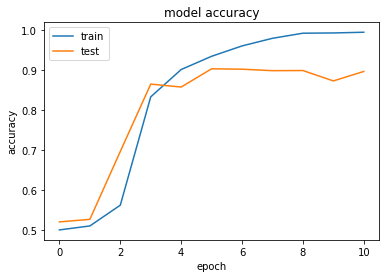

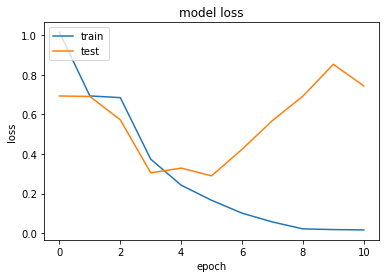

In [22]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

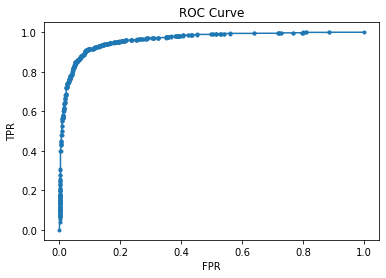

0.9617993079584776


In [23]:
from sklearn.metrics import roc_curve, auc

y_pred = model.predict(X_test).ravel()

nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)
plt.title('ROC Curve')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

print(auc_keras)

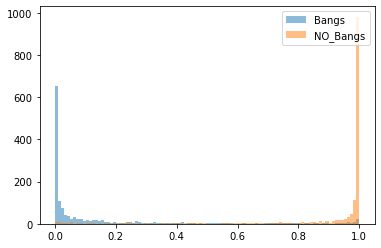

In [24]:
from matplotlib import pyplot
predict_x=model.predict(X_test) 

Bangs_index = np.where(y_test.reshape(-1) == 0.)
Bangs = predict_x[Bangs_index]

NO_Bangs_index = np.where(y_test.reshape(-1) == 1.)
NO_Bangs = predict_x[NO_Bangs_index]



bins = np.linspace(0, 1, 100)

pyplot.hist(Bangs, bins, alpha=0.5, label='Bangs')
pyplot.hist(NO_Bangs, bins, alpha=0.5, label='NO_Bangs')
pyplot.legend(loc='upper right')
pyplot.show()